# Microsoft malware classification
_Klasifikacija zlonamjernog softvera_

PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK<br>
Projektni prijedlog iz kolegija Strojno učenje <br>
__Travanj 2020.__ <br>

_Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita_

<br>

Jedna od najfinanciranijih i bitnijih IT industrija današnjice zasigurno je ona koja se bavi _malwareima_. Kako se većina zlonamjernog softvera kreira konstantnim (_malicioznim_) mjenjanjem već postojećih _malwarea_, dolazi na važnost njihovo klasificiranje. 

Ideja za projekt dolazi sa [Kaggle natječaja](https://www.kaggle.com/c/malware-classification/overview) - _Microsoft malware classification_.<br>

U ovoj _Jupiter_ bilježnici prikazati ćemo podatke koje je omogućio natječaj. Orginalni podaci veličine su oko pola TB te su podjeljeni u podatke za treniranje i testiranje. Podaci za treniranje algoritma za klasifikaciju imaju specificiranu klasu familije kojoj pripada svaki od _malwarea_. Moguće su sljedeće familije:
    1. Ramnit
    2. Lollipop
    3. Kelihos_ver3
    4. Vundo
    5. Simba
    6. Tracur
    7. Kelihos_ver1
    8. Obfuscator.ACY
    9. Gatak

Potrebno je, za svaki _malware_ identificiran jedinstvenim _hash_ kodom iz podataka za testiranje, odrediti kojoj od navedenih klasa pripada. <br> 

Podaci za svaki _malware_ sastoje se od dvije datoteke:
 - __.bytes__ koja sadrži heksadecimalnu reprezentaciju binarnog sadržaja _malwarea_
 - __.asm__ koja sadrži metapodatke izvučene iz binarnih podatataka (npr. korištene funkcije i stringovi u asemblerskom kodu)
<br> <br>


Primjer dvije linije iz jedne __.bytes__ datoteke:

<code>00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08
00401010 BB 42 00 8B C6 5E C2 04 00 CC CC CC CC CC CC CC</code>

Prvi broj, npr <code> 00401000 </code> označava početak adrese desno napisane heksadecimalne reprezentacije binarnog koda u memoriji. Ostale, desne, heksadecimalne vrijednosti predstavljaju važne informacije o samom _malwareu_, npr. instrukcije u kodu. To se može vidjeti i u primjeru nekoliko linija iz jedne __.asm__ datoteke:

<code>.text:00401016						       ; ---------------------------------------------------------------------------
.text:00401019 CC CC CC	CC CC CC CC					       align 10h
.text:00401020 C7 01 08	BB 42 00					       mov     dword ptr [ecx],	offset off_42BB08
.text:00401026 E9 26 1C	00 00						       jmp     sub_402C51
.text:00401026						       ; ---------------------------------------------------------------------------</code>


<br>
<br>

In [20]:
# import needed libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn as sk

## Analiza značajki 
_Features analysis_

_KOMENTAR_ 
[//]: # "Po uzoru na https://github.com/PMF-StrojnoUcenje2018/Overflow/blob/master/pocetna_analiza.ipynb"

Kako orginalni podaci nemaju točno određene _feature_ koje bi upotrijebili u algoritmu za klasificiranje, rudarili smo podatke po uzoru na članak: [_Novel Feature Extraction, Selection and Fusion for Effective Malware Family Classification_](https://www.researchgate.net/publication/283986464_Novel_Feature_Extraction_Selection_and_Fusion_for_Effective_Malware_Family_Classification) korišteći njihov gotovi [kod](https://github.com/ManSoSec/Microsoft-Malware-Challenge) koji su objavili, uz male promjene. Kratka analiza i pregled koda može se vidjeti u [feature_extraction.ipynb]. 

_KOMENTAR_
[//]: # "Treba dodati link na ovu bbilježnicu"

In [83]:
# rječnik za pamćenje imena klasa malwarea
malware_dict = { 1 : 'Ramnit', 2 : 'Lollipop', 3 : 'Kelihos_ver3', 4 : 'Vundo', 5 : 'Simba', 
                 6 : 'Tracur', 7 : 'Kelihos_ver1', 8 : 'Obfuscator.ACY', 9 : 'Gatak'}

# malware imena onim redosljedom kako su se značajke izvlačile, dakle onim redom kako su u csv datotekama
malware_names = np.loadtxt("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/byte_filenames.txt", dtype='str')

# csv datoteka koje za svaki malware (stupac Id) ima klasu kojoj on pripada (supac Class)
malware_labels = pd.read_csv("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/train_labels.csv")

###  _featuri_ dobivene iz __.bytes__ datoteke

#### 1 - gram 
_1G_

In [19]:
# unos 1G značajki
one_gram = pd.read_csv("https://raw.githubusercontent.com/tomarga/Machine-Burning/master/dataset/byte_oneg.csv")

In [85]:
# rječnik sa raspoređenim značajkama ovisno o klasi u kojoj se malware nalazi
one_gram_classes = {}
index = 0

for i in range(len(malware_names)):
    label = malware_labels.Class[ malware_labels.Id == malware_names[i] ].item()
    malware_name = malware_dict[label]
    
    if malware_name not in one_gram_classes:
        one_gram_classes[malware_name] = one_gram.iloc[i].to_numpy()
        continue
    
    one_gram_classes[malware_name] = np.vstack( [ one_gram_classes[malware_name], one_gram.iloc[i].to_numpy() ] )


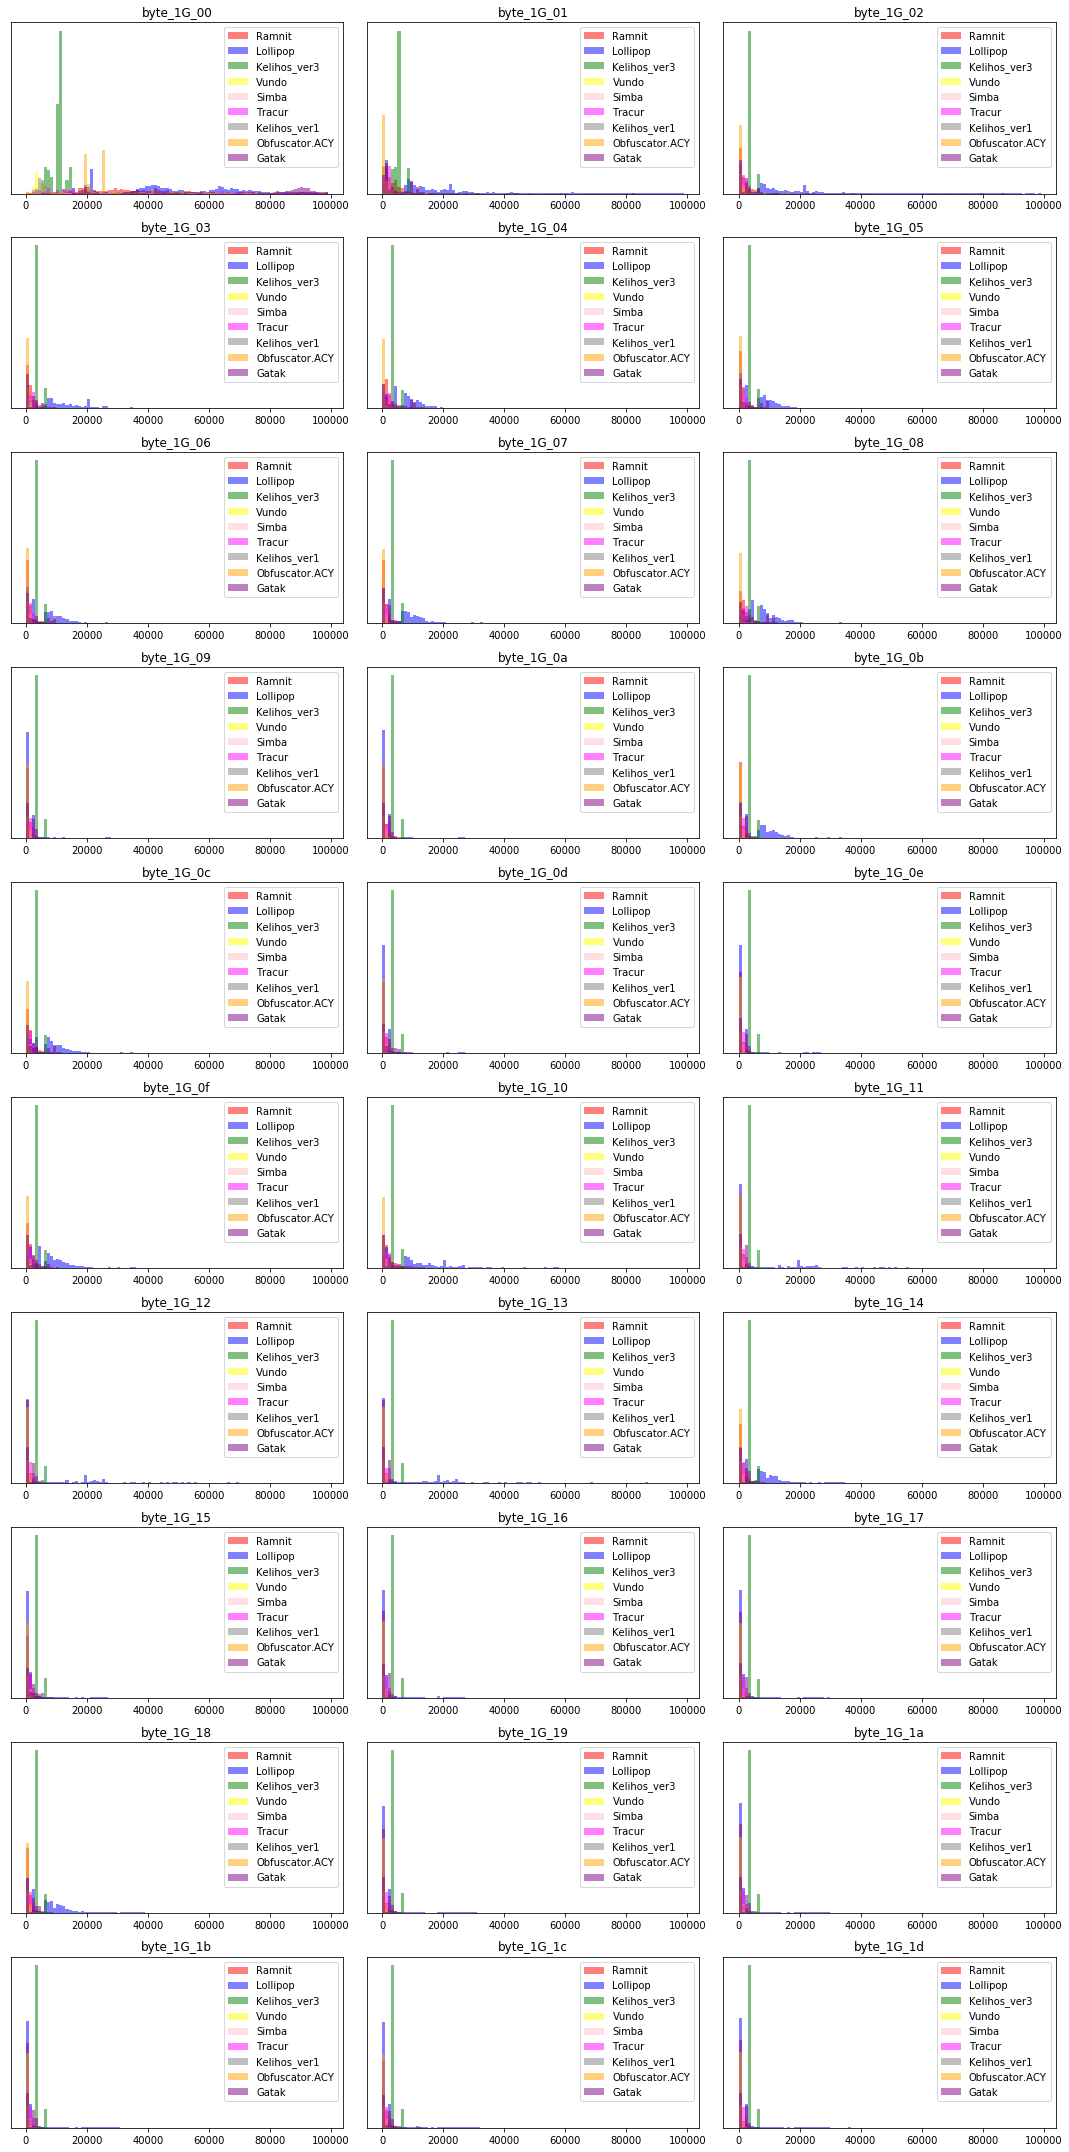

In [108]:
fig, axes = plt.subplots(10,3, figsize=(15, 30))
ax = axes.ravel() # axes are 2-dimensional so we unfold them

# ovo je samo za 30 stupaca od ukupno 256  značajki one grama
for i in range(30):
    #_, bins = np.histogram(one_gram.iloc[:,i], bins=50) 
    # ovo je za ravnomjernu raspodjelu max-min (ako se ne varam) ali na histogramima se ne vidi lijepo raspodjela podataka u tom slučaju
    # probala sam sa ovim dolje binsom, probati mozda sa meanom ili tako nešto
    bins = [ i*1000 for i in range(100)]

    ax[i].hist(one_gram_classes[malware_dict[1]][:,i], bins=bins, color='red', alpha=.5, label=malware_dict[1])
    ax[i].hist(one_gram_classes[malware_dict[2]][:,i], bins=bins, color='blue', alpha=.5, label=malware_dict[2])
    ax[i].hist(one_gram_classes[malware_dict[3]][:,i], bins=bins, color='green', alpha=.5, label=malware_dict[3])
    ax[i].hist(one_gram_classes[malware_dict[4]][:,i], bins=bins, color='yellow', alpha=.5, label=malware_dict[4])
    ax[i].hist(one_gram_classes[malware_dict[5]][:,i], bins=bins, color='pink', alpha=.5, label=malware_dict[5])
    ax[i].hist(one_gram_classes[malware_dict[6]][:,i], bins=bins, color='magenta', alpha=.5, label=malware_dict[6])
    ax[i].hist(one_gram_classes[malware_dict[7]][:,i], bins=bins, color='grey', alpha=.5, label=malware_dict[7])
    ax[i].hist(one_gram_classes[malware_dict[8]][:,i], bins=bins, color='orange', alpha=.5, label=malware_dict[8])
    ax[i].hist(one_gram_classes[malware_dict[9]][:,i], bins=bins, color='purple', alpha=.5, label=malware_dict[9])

    ax[i].set_title(one_gram.columns.values[i])
    ax[i].set_yticks(()) # remove ticks on y-axis
    ax[i].legend(loc='upper right')
    
fig.tight_layout()

#### (byte) metadata 
_MDB_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

#### entropija
_ENT_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

#### slikovna reprezentacija virusa
_IMG_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

#### duljina stringova
_STR_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

<br>
<br>

### _featuri_ dobiveni iz .asm datoteke

#### (asm) metadata
_MDA_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

#### simboli
_SYM_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

#### opcode
_OPC_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

#### registri
_REG_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

#### API
_API_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

#### sekcije
_SEC_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

#### _data define_
_DP_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

#### ključne riječi
_KEYW_

In [ ]:
# grafikoni i tablice jednom kad se završi kompresija podataka

<br>
<br>

## Odabir najznačajnijih značajki
_Feature fusion_

_KOMENTAR_
[//]: # "Možemo npr ovako https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e"

In [ ]:
# ovo nije kod za nase podatke! 
# niti mozda onaj koji cemo mi koristiti, po danasnjim vjezbama, trebalo bi vjerojatno raditi onu uninvarijantnu metodu
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html

# FEATURE IMPORTANCE
# Feature importance is an inbuilt class that comes with Tree Based Classifiers, 
# we will be using Extra Tree Classifier for extracting the top 10 features for the dataset.

import pandas as pd
import numpy as np

data = pd.read_csv("D://Blogs//train.csv") #path to data
X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()